# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.4 MB/s eta 0:00:00


In [2]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [3]:
from google.colab import files
mat_data = files.upload()

Saving Xtrain.mat to Xtrain.mat


## Global Definitions

In [4]:
# Path to the zip file
data_dir = "./Data"
data_path = "Xtrain.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Set a professional style for the plots
sns.set_theme(style="whitegrid")

In [5]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.6.0+cu124
12.4
90300
True


### Utilities

In [6]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, attempt_index, epochs=20, lr=1e-3, teacher_forcing_prob=0.5, patience=10):
    """
    Train the given model with validation and return the final validation L1 loss.
    Includes early stopping based on validation loss.
    Logs all metrics (L1, MSE, MAE) for each epoch into a DataFrame.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    # Define loss functions
    huberLoss_criterion = nn.HuberLoss()  # Huber Loss
    mse_criterion = nn.MSELoss()  # MSE Loss
    mae_criterion = nn.L1Loss()  # MAE Loss (same as L1 Loss)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state
    no_improvement_epochs = 0  # Counter for early stopping

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_l1", "train_mse", "train_mae", "val_l1", "val_mse", "val_mae"])

    # Progress bar for epochs
    epochs_pbar = tqdm(range(epochs), desc=f"Trial: {attempt_index}", unit="epoch")

    for epoch in epochs_pbar:
        # Training phase
        model.train()
        running_train_huberLoss_loss = 0.0
        running_train_mse_loss = 0.0
        running_train_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            # Calculate loss
            huberLoss_loss = huberLoss_criterion(output, y_batch)
            mse_loss = mse_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_train_huberLoss_loss += huberLoss_loss.item()
            running_train_mse_loss += mse_loss.item()
            running_train_mae_loss += mae_loss.item()

            # Backward pass
            optimizer.zero_grad()
            mae_loss.backward()
            optimizer.step()

        avg_train_huberLoss_loss = running_train_huberLoss_loss / len(train_loader)
        avg_train_mse_loss = running_train_mse_loss / len(train_loader)
        avg_train_mae_loss = running_train_mae_loss / len(train_loader)

        # Validation phase
        model.eval()
        running_val_huberLoss_loss = 0.0
        running_val_mse_loss = 0.0
        running_val_mae_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)

                huberLoss_loss = huberLoss_criterion(output, y_batch)
                mse_loss = mse_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_val_huberLoss_loss += huberLoss_loss.item()
                running_val_mse_loss += mse_loss.item()
                running_val_mae_loss += mae_loss.item()

        avg_val_huberLoss_loss = running_val_huberLoss_loss / len(val_loader)
        avg_val_mse_loss = running_val_mse_loss / len(val_loader)
        avg_val_mae_loss = running_val_mae_loss / len(val_loader)

        # Save metrics to DataFrame
        new_row = pd.DataFrame([{
            "trial_id": attempt_index,
            "epoch": epoch + 1,
            "train_HuberLoss": avg_train_huberLoss_loss,
            "train_MSE": avg_train_mse_loss,
            "train_MAE": avg_train_mae_loss,
            "val_HuberLoss": avg_val_huberLoss_loss,
            "val_MSE": avg_val_mse_loss,
            "val_MAE": avg_val_mae_loss
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the best model
        if avg_val_mae_loss < best_val_loss:
            best_val_loss = avg_val_mae_loss
            best_model_state = model.state_dict()
            no_improvement_epochs = 0  # Reset early stopping counter
        else:
            no_improvement_epochs += 1  # Increment early stopping counter

        # Early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # Adjust learning rate
        scheduler.step()

        # Update progress bar
        epochs_pbar.set_postfix(
            Train_huberLoss_Loss=avg_train_huberLoss_loss,
            Train_MSE_Loss=avg_train_mse_loss,
            Train_MAE_Loss=avg_train_mae_loss,
            Val_huberLoss_Loss=avg_val_huberLoss_loss,
            Val_MSE_Loss=avg_val_mse_loss,
            Val_MAE_Loss=avg_val_mae_loss,
        )

    # Load the best model
    model.load_state_dict(best_model_state)

    return best_val_loss, metrics_df  # Return the best validation L1 loss and metrics DataFrame

### Gated Recurrent Unit (GRU) RNN Model

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.dropout = dropout

        self.gru = nn.GRU(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


### Load and Split the dataset into train-validation

In [8]:
data = loadmat(data_path)
measurements = data['Xtrain']
# Check the shape of the data
print("Shape of measurements:", measurements.shape)

# Display the first few rows of the data
print(f"First 5 measurements: {measurements[:5]}")

print(f"measurements range: min={measurements.min()}, max={measurements.max()}")

# Creating sequences
max_window_size = 50  # Maximum window size
# Split data into training and validation sets
size_of_test = 200 + max_window_size  # 200 steps for testing + window size
train_data, val_data = measurements[:-size_of_test], measurements[-size_of_test:]

# Normalize the training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Normalize the validation data using the same scaler
val_data_normalized = scaler.transform(val_data)

# Creating sequences
train_dataset, val_dataset = train_data_normalized, val_data_normalized

print(f"Train shape: {train_dataset.shape}, Val shape: {val_dataset.shape}")
print(f"train_dataset range: min={train_dataset.min()}, max={train_dataset.max()}")
print(f"val_dataset range: min={val_dataset.min()}, max={val_dataset.max()}")

Shape of measurements: (1000, 1)
First 5 measurements: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
measurements range: min=2, max=255
Train shape: (750, 1), Val shape: (250, 1)
train_dataset range: min=0.0, max=1.0
val_dataset range: min=0.03952569169960474, max=0.6996047430830039


### Training the Model

In [9]:
best_model = None

# Initialize a global DataFrame to store metrics for all trials
all_metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_HuberLoss", "train_MSE", "train_MAE", "val_HuberLoss", "val_MSE", "val_MAE",
                                       "hidden_size", "num_layers", "learning_rate", "batch_size", "window_size", "dropout"])

def objective(trial):
    global all_metrics_df  # Use the global DataFrame to store metrics

    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    window_size = trial.suggest_int('window_size', 5, 100, step=1)
    dropout = trial.suggest_float('dropout', 1e-1, 3e-1, log=True)

    # Update data loaders with the suggested batch size
    train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
    val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)

    # Define the model
    model = GRU(
        input_size=1,  # Number of features in the input sequence
        hidden_size=hidden_size,
        num_stacked_layers=num_layers,
        dropout=dropout
    ).to(device)

    # Train the model and get the final validation loss and metrics DataFrame
    trial_index = trial.number + 1  # Start from 1 for better readability in logs
    val_loss, metrics_df = train_model(
        model, train_loader, val_loader, attempt_index=trial_index, epochs=100, lr=learning_rate
    )

    # Add trial parameters to the metrics DataFrame
    metrics_df["hidden_size"] = hidden_size
    metrics_df["num_layers"] = num_layers
    metrics_df["learning_rate"] = learning_rate
    metrics_df["batch_size"] = batch_size
    metrics_df["window_size"] = window_size
    metrics_df["dropout"] = dropout

    # Save the best model
    if trial.number == 0 or val_loss < study.best_value:
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved with trial {trial.number}")
        best_model = model

        # Save the best hyperparameters
        with open("best_hyperparameters.json", "w") as f:
            json.dump({
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "window_size": window_size,
                "dropout": dropout
            }, f)

    # Append the metrics for this trial to the global DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    return val_loss  # Optuna will minimize this


# Create a study object
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Optimize the objective function
study.optimize(objective, n_trials=250)  # Run 100 trials

# Save the combined metrics DataFrame to a CSV file
all_metrics_df.to_csv("all_trials_metrics.csv", index=False)
print("All metrics saved to all_trials_metrics.csv")

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Print the best validation loss
print("Best validation loss:", study.best_value)

# Load the best model
best_model = GRU(
    input_size=1,
    hidden_size=study.best_params['hidden_size'],
    num_stacked_layers=study.best_params['num_layers'],
    dropout = study.best_params['dropout']
).to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
print("Best model loaded.")

# Update train_loader and val_loader with the best hyperparameters
train_loader, train_X, train_y = prepare_dataloader(train_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
val_loader, val_X, val_y = prepare_dataloader(val_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
print("Data loaders updated with best hyperparameters.")

[I 2025-05-07 10:40:03,937] A new study created in memory with name: no-name-0e53d3f1-86ec-43d2-b6df-0f1674fe6c22


Trial: 1:   0%|          | 0/100 [00:00<?, ?epoch/s]

<ipython-input-9-4bab54d56dc4>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
[I 2025-05-07 10:40:15,291] Trial 0 finished with value: 0.01549093029461801 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0053850045895157475, 'batch_size': 64, 'window_size': 29, 'dropout': 0.1077603464160873}. Best is trial 0 with value: 0.01549093029461801.


Early stopping triggered after 22 epochs.
Best model saved with trial 0


Trial: 2:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:40:18,723] Trial 1 finished with value: 0.013558883219957352 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.004847457927210011, 'batch_size': 128, 'window_size': 77, 'dropout': 0.11065409672677104}. Best is trial 1 with value: 0.013558883219957352.


Early stopping triggered after 46 epochs.
Best model saved with trial 1


Trial: 3:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:40:24,778] Trial 2 finished with value: 0.016997614409774542 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0033591504907255873, 'batch_size': 128, 'window_size': 63, 'dropout': 0.264477355321224}. Best is trial 1 with value: 0.013558883219957352.


Early stopping triggered after 45 epochs.


Trial: 4:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:40:29,058] Trial 3 finished with value: 0.1521533340215683 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 1.6208381647845225e-05, 'batch_size': 32, 'window_size': 98, 'dropout': 0.2993898253934029}. Best is trial 1 with value: 0.013558883219957352.


Early stopping triggered after 14 epochs.


Trial: 5:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:40:30,626] Trial 4 finished with value: 0.012313679791986942 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 0.009418816171094456, 'batch_size': 128, 'window_size': 66, 'dropout': 0.2311297657673701}. Best is trial 4 with value: 0.012313679791986942.


Early stopping triggered after 23 epochs.
Best model saved with trial 4


Trial: 6:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:40:38,148] Trial 5 finished with value: 0.04229017719626427 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.0003457344453295128, 'batch_size': 128, 'window_size': 61, 'dropout': 0.13292217920541574}. Best is trial 4 with value: 0.012313679791986942.


Trial: 7:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:40:42,554] Trial 6 finished with value: 0.006586155721119472 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.005511879730227313, 'batch_size': 32, 'window_size': 36, 'dropout': 0.14543482665015026}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 22 epochs.
Best model saved with trial 6


Trial: 8:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:40:48,356] Trial 7 finished with value: 0.1500814805428187 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 3.1026773266516185e-05, 'batch_size': 64, 'window_size': 77, 'dropout': 0.18596951439485293}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 52 epochs.


Trial: 9:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:41:06,823] Trial 8 finished with value: 0.0872840593968119 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 3.728965019505599e-05, 'batch_size': 32, 'window_size': 38, 'dropout': 0.17655026498898843}. Best is trial 6 with value: 0.006586155721119472.


Trial: 10:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:41:10,770] Trial 9 finished with value: 0.011050002250288214 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 0.003987702638168894, 'batch_size': 32, 'window_size': 41, 'dropout': 0.1973475405253843}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 20 epochs.


Trial: 11:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:41:15,553] Trial 10 finished with value: 0.03325060405768454 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.000823412709644308, 'batch_size': 32, 'window_size': 6, 'dropout': 0.1426424193493662}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 22 epochs.


Trial: 12:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:41:23,209] Trial 11 finished with value: 0.006735240042741809 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 0.001231797566271122, 'batch_size': 32, 'window_size': 36, 'dropout': 0.2089561374161121}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 39 epochs.


Trial: 13:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:41:30,972] Trial 12 finished with value: 0.009220068051945418 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.001078009219112404, 'batch_size': 32, 'window_size': 19, 'dropout': 0.14853023610672303}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 39 epochs.


Trial: 14:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:41:35,111] Trial 13 finished with value: 0.02066366613975593 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0012895781568960563, 'batch_size': 32, 'window_size': 45, 'dropout': 0.21268482259406232}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 22 epochs.


Trial: 15:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:41:51,396] Trial 14 finished with value: 0.01207292650360614 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.0001292757504633109, 'batch_size': 32, 'window_size': 21, 'dropout': 0.1587465957410524}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 78 epochs.


Trial: 16:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:42:02,970] Trial 15 finished with value: 0.014661131692784173 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.00034648408671284956, 'batch_size': 32, 'window_size': 30, 'dropout': 0.12694550541606892}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 62 epochs.


Trial: 17:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:42:11,814] Trial 16 finished with value: 0.010919868247583508 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0013321222517056976, 'batch_size': 64, 'window_size': 53, 'dropout': 0.2402590204775419}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 42 epochs.


Trial: 18:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:42:16,756] Trial 17 finished with value: 0.018940238282084465 and parameters: {'hidden_size': 64, 'num_layers': 3, 'lr': 0.0024964526679739666, 'batch_size': 32, 'window_size': 7, 'dropout': 0.16428245150983853}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 22 epochs.


Trial: 19:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:42:33,268] Trial 18 finished with value: 0.054416250969682424 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.00011824561882264177, 'batch_size': 32, 'window_size': 48, 'dropout': 0.12179875541256785}. Best is trial 6 with value: 0.006586155721119472.


Trial: 20:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:42:36,625] Trial 19 finished with value: 0.010465814033523202 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00944634076782416, 'batch_size': 64, 'window_size': 32, 'dropout': 0.20111818784440946}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 20 epochs.


Trial: 21:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:42:45,158] Trial 20 finished with value: 0.009233142365701497 and parameters: {'hidden_size': 64, 'num_layers': 3, 'lr': 0.0006066484820357353, 'batch_size': 32, 'window_size': 20, 'dropout': 0.17748091122387555}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 42 epochs.


Trial: 22:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:42:53,836] Trial 21 finished with value: 0.0071836672723293304 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.0016312926390484213, 'batch_size': 32, 'window_size': 20, 'dropout': 0.1486201878837414}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 42 epochs.


Trial: 23:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:42:58,295] Trial 22 finished with value: 0.02814896614290774 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.0021175184956126977, 'batch_size': 32, 'window_size': 18, 'dropout': 0.15075154826224754}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 23 epochs.


Trial: 24:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:43:03,397] Trial 23 finished with value: 0.01172357045912317 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 0.0017444362783808577, 'batch_size': 32, 'window_size': 33, 'dropout': 0.14185577302160984}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 22 epochs.


Trial: 25:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:43:12,778] Trial 24 finished with value: 0.007514668279327452 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.0006401610366130898, 'batch_size': 32, 'window_size': 13, 'dropout': 0.16268135798147684}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 42 epochs.


Trial: 26:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:43:31,670] Trial 25 finished with value: 0.036987692915967534 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.00017377232211830457, 'batch_size': 32, 'window_size': 53, 'dropout': 0.10010960370324258}. Best is trial 6 with value: 0.006586155721119472.


Trial: 27:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:43:35,691] Trial 26 finished with value: 0.009656218678823538 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.005672762969802533, 'batch_size': 32, 'window_size': 27, 'dropout': 0.21788099421457363}. Best is trial 6 with value: 0.006586155721119472.


Early stopping triggered after 20 epochs.


Trial: 28:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:43:43,557] Trial 27 finished with value: 0.006348590832203627 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.0029597828702056165, 'batch_size': 32, 'window_size': 40, 'dropout': 0.11880069621066207}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 40 epochs.
Best model saved with trial 27


Trial: 29:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:43:47,572] Trial 28 finished with value: 0.010089334798976779 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0026623029632717645, 'batch_size': 64, 'window_size': 39, 'dropout': 0.11848763682390494}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 39 epochs.


Trial: 30:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:43:53,530] Trial 29 finished with value: 0.007582927588373423 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.008050785114553842, 'batch_size': 128, 'window_size': 48, 'dropout': 0.11457567103605346}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 65 epochs.


Trial: 31:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:43:55,460] Trial 30 finished with value: 0.018124269787222147 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.005354858177641988, 'batch_size': 64, 'window_size': 57, 'dropout': 0.10272513777158541}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 20 epochs.


Trial: 32:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:44:03,128] Trial 31 finished with value: 0.013890281718756472 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.001792918700137428, 'batch_size': 32, 'window_size': 26, 'dropout': 0.13322059104785464}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 42 epochs.


Trial: 33:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:44:07,167] Trial 32 finished with value: 0.01487997267395258 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.003616593689332724, 'batch_size': 32, 'window_size': 36, 'dropout': 0.13321808777989144}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 19 epochs.


Trial: 34:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:44:10,934] Trial 33 finished with value: 0.014502572594210505 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.0059777595223827655, 'batch_size': 32, 'window_size': 25, 'dropout': 0.10937551904677621}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 22 epochs.


Trial: 35:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:44:23,053] Trial 34 finished with value: 0.015282764798030257 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.0005313526194091942, 'batch_size': 32, 'window_size': 12, 'dropout': 0.25893698946261134}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 62 epochs.


Trial: 36:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:44:27,791] Trial 35 finished with value: 0.007021736353635788 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0033747398055601584, 'batch_size': 128, 'window_size': 43, 'dropout': 0.15362377638221802}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 42 epochs.


Trial: 37:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:44:31,721] Trial 36 finished with value: 0.021933230571448803 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0029736895973748547, 'batch_size': 128, 'window_size': 68, 'dropout': 0.1892800014924848}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 45 epochs.


Trial: 38:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:44:34,604] Trial 37 finished with value: 0.02026856690645218 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0036724195569524014, 'batch_size': 128, 'window_size': 46, 'dropout': 0.16996829392101231}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 25 epochs.


Trial: 39:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:44:38,375] Trial 38 finished with value: 0.008987991604954004 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0066950186495521, 'batch_size': 128, 'window_size': 42, 'dropout': 0.29142844792575656}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 42 epochs.


Trial: 40:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:44:51,332] Trial 39 finished with value: 0.015973572619259357 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0010221469756947683, 'batch_size': 128, 'window_size': 100, 'dropout': 0.1258818071089254}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 79 epochs.


Trial: 41:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:44:56,131] Trial 40 finished with value: 0.021321802400052547 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.004370400895155887, 'batch_size': 128, 'window_size': 89, 'dropout': 0.13898167440684514}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 24 epochs.


Trial: 42:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:45:05,235] Trial 41 finished with value: 0.010084051173180342 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0017260600356277498, 'batch_size': 128, 'window_size': 35, 'dropout': 0.15253038350348008}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 45 epochs.


Trial: 43:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:45:09,536] Trial 42 finished with value: 0.00810458351458822 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 0.0030400535707690284, 'batch_size': 32, 'window_size': 42, 'dropout': 0.1547296423746037}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 20 epochs.


Trial: 44:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:45:15,975] Trial 43 finished with value: 0.016154366545379162 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0008777013847822731, 'batch_size': 32, 'window_size': 59, 'dropout': 0.17401656717365926}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 22 epochs.


Trial: 45:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:45:23,802] Trial 44 finished with value: 0.008410645474214107 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.001418878862046326, 'batch_size': 32, 'window_size': 24, 'dropout': 0.14497955420771988}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 38 epochs.


Trial: 46:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:45:27,654] Trial 45 finished with value: 0.008393124677240849 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.0023126578716688756, 'batch_size': 128, 'window_size': 38, 'dropout': 0.1377591598768031}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 39 epochs.


Trial: 47:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:45:31,987] Trial 46 finished with value: 0.009542298237127917 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.004617879243529445, 'batch_size': 32, 'window_size': 31, 'dropout': 0.18598816907824983}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 20 epochs.


Trial: 48:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:45:38,723] Trial 47 finished with value: 0.14849042147397995 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 1.167973580028522e-05, 'batch_size': 32, 'window_size': 67, 'dropout': 0.12871269162163426}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 34 epochs.


Trial: 49:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:45:44,573] Trial 48 finished with value: 0.015701642725616693 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0004417006488812444, 'batch_size': 64, 'window_size': 50, 'dropout': 0.2074456336292755}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 38 epochs.


Trial: 50:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:45:48,633] Trial 49 finished with value: 0.011949956816221987 and parameters: {'hidden_size': 64, 'num_layers': 3, 'lr': 0.007857920077170014, 'batch_size': 32, 'window_size': 54, 'dropout': 0.22372570905044867}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 22 epochs.


Trial: 51:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:45:54,695] Trial 50 finished with value: 0.13944271951913834 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.00020078011791601033, 'batch_size': 128, 'window_size': 44, 'dropout': 0.1677520614210001}. Best is trial 27 with value: 0.006348590832203627.


Trial: 52:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:46:04,358] Trial 51 finished with value: 0.009230203228071332 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.0007349524981826932, 'batch_size': 32, 'window_size': 14, 'dropout': 0.15434133232555428}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 42 epochs.


Trial: 53:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:46:09,960] Trial 52 finished with value: 0.01858334499411285 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.0011078326483262887, 'batch_size': 32, 'window_size': 11, 'dropout': 0.15978361667715452}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 22 epochs.


Trial: 54:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:46:19,495] Trial 53 finished with value: 0.007659790513571352 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.0006546559914982909, 'batch_size': 32, 'window_size': 18, 'dropout': 0.16364189682355182}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 42 epochs.


Trial: 55:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:46:24,328] Trial 54 finished with value: 0.02189799037296325 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.001435514027501615, 'batch_size': 32, 'window_size': 8, 'dropout': 0.17913050926223098}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 22 epochs.


Trial: 56:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:46:35,327] Trial 55 finished with value: 0.00905754610097834 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.00039799253690697494, 'batch_size': 32, 'window_size': 30, 'dropout': 0.2408959574897317}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 39 epochs.


Trial: 57:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:46:42,680] Trial 56 finished with value: 0.014688592520542443 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.00029342671630061, 'batch_size': 32, 'window_size': 14, 'dropout': 0.1941056927816719}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 38 epochs.


Trial: 58:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:46:45,948] Trial 57 finished with value: 0.1330102439969778 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 4.041435120722698e-05, 'batch_size': 32, 'window_size': 22, 'dropout': 0.14440921213130412}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 11 epochs.


Trial: 59:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:46:50,176] Trial 58 finished with value: 0.00966408452950418 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0021761624471930345, 'batch_size': 64, 'window_size': 36, 'dropout': 0.11511284031559252}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 42 epochs.


Trial: 60:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:46:54,474] Trial 59 finished with value: 0.010890018793621234 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0019578019137026993, 'batch_size': 32, 'window_size': 39, 'dropout': 0.14928303512774208}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 20 epochs.


Trial: 61:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:46:59,880] Trial 60 finished with value: 0.03766749333590269 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.0008953945587774817, 'batch_size': 32, 'window_size': 5, 'dropout': 0.1811321524279042}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 22 epochs.


Trial: 62:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:03,358] Trial 61 finished with value: 0.008031826466321945 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.00971700998788264, 'batch_size': 128, 'window_size': 48, 'dropout': 0.11391375844876706}. Best is trial 27 with value: 0.006348590832203627.


Early stopping triggered after 40 epochs.


Trial: 63:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:09,086] Trial 62 finished with value: 0.0050156081560999155 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0044081146781172606, 'batch_size': 128, 'window_size': 49, 'dropout': 0.12174072162192325}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 63 epochs.
Best model saved with trial 62


Trial: 64:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:12,982] Trial 63 finished with value: 0.00790179381147027 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0036072525283925667, 'batch_size': 128, 'window_size': 34, 'dropout': 0.12414458166587174}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 63 epochs.


Trial: 65:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:22,093] Trial 64 finished with value: 0.010695139411836863 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0029970430044716084, 'batch_size': 128, 'window_size': 56, 'dropout': 0.11988254115652328}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 45 epochs.


Trial: 66:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:24,659] Trial 65 finished with value: 0.01000427920371294 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.004704163954047019, 'batch_size': 128, 'window_size': 51, 'dropout': 0.1070568420150958}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 40 epochs.


Trial: 67:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:28,297] Trial 66 finished with value: 0.007141176943800279 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.006667892013857796, 'batch_size': 32, 'window_size': 28, 'dropout': 0.15931718929612573}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 20 epochs.


Trial: 68:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:31,973] Trial 67 finished with value: 0.009411647383655821 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.00758681722272483, 'batch_size': 32, 'window_size': 28, 'dropout': 0.13598529333697298}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 20 epochs.


Trial: 69:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:35,048] Trial 68 finished with value: 0.010919197928160429 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.006500348400241111, 'batch_size': 128, 'window_size': 45, 'dropout': 0.1285197770971386}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 39 epochs.


Trial: 70:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:37,482] Trial 69 finished with value: 0.01836222014389932 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.005049829570725705, 'batch_size': 64, 'window_size': 42, 'dropout': 0.1460995842581221}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 22 epochs.


Trial: 71:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:40,863] Trial 70 finished with value: 0.014582060144415923 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0024808634933887737, 'batch_size': 32, 'window_size': 32, 'dropout': 0.10536863739220881}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 19 epochs.


Trial: 72:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:45,688] Trial 71 finished with value: 0.010898274602368474 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.003994943511161849, 'batch_size': 32, 'window_size': 17, 'dropout': 0.15992479512073432}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 22 epochs.


Trial: 73:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:49,510] Trial 72 finished with value: 0.014153289725072682 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0016167635606881559, 'batch_size': 32, 'window_size': 22, 'dropout': 0.16627243381418544}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 19 epochs.


Trial: 74:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:53,696] Trial 73 finished with value: 0.01829148828983307 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.001126818337051637, 'batch_size': 32, 'window_size': 63, 'dropout': 0.15691746480720695}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 19 epochs.


Trial: 75:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:47:57,996] Trial 74 finished with value: 0.020253499570701803 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.002803004007577986, 'batch_size': 32, 'window_size': 39, 'dropout': 0.17129224203166044}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 22 epochs.


Trial: 76:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:48:02,645] Trial 75 finished with value: 0.009917196684650012 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.005834852118769461, 'batch_size': 32, 'window_size': 29, 'dropout': 0.16058737286159544}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 20 epochs.


Trial: 77:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:48:06,278] Trial 76 finished with value: 0.00733596202917397 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.003371328945756232, 'batch_size': 128, 'window_size': 24, 'dropout': 0.13854874218599467}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 63 epochs.


Trial: 78:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:48:08,788] Trial 77 finished with value: 0.01746361143887043 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.0035870030054859716, 'batch_size': 128, 'window_size': 27, 'dropout': 0.14007011514243697}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 43 epochs.


Trial: 79:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:48:11,631] Trial 78 finished with value: 0.012958989478647709 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.007028271623079374, 'batch_size': 128, 'window_size': 24, 'dropout': 0.13013401247528097}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 37 epochs.


Trial: 80:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:48:14,194] Trial 79 finished with value: 0.013033939525485039 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.003206487401348873, 'batch_size': 128, 'window_size': 34, 'dropout': 0.14765076718723155}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 43 epochs.


Trial: 81:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:48:16,529] Trial 80 finished with value: 0.019109094515442848 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.004218349286157759, 'batch_size': 128, 'window_size': 37, 'dropout': 0.13461702802665432}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 39 epochs.


Trial: 82:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:48:19,448] Trial 81 finished with value: 0.008322546724230051 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.002392173900763704, 'batch_size': 128, 'window_size': 21, 'dropout': 0.1506914222923916}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 42 epochs.


Trial: 83:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:48:27,278] Trial 82 finished with value: 0.007305489212740213 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lr': 0.00537250704414944, 'batch_size': 32, 'window_size': 10, 'dropout': 0.14231535734438458}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 42 epochs.


Trial: 84:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:48:39,596] Trial 83 finished with value: 0.009846831177128479 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lr': 0.005496782459560295, 'batch_size': 32, 'window_size': 16, 'dropout': 0.14148670436558208}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 39 epochs.


Trial: 85:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:48:41,644] Trial 84 finished with value: 0.015017121564596891 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lr': 0.00908050382704382, 'batch_size': 128, 'window_size': 40, 'dropout': 0.12255458746537307}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 38 epochs.


Trial: 86:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:48:44,920] Trial 85 finished with value: 0.015593119664117694 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.004932621569833212, 'batch_size': 32, 'window_size': 8, 'dropout': 0.11872772656525851}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 19 epochs.


Trial: 87:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:02,008] Trial 86 finished with value: 0.13661520715270722 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lr': 6.388864786994699e-05, 'batch_size': 32, 'window_size': 47, 'dropout': 0.14269995841479813}. Best is trial 62 with value: 0.0050156081560999155.


Trial: 88:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:06,494] Trial 87 finished with value: 0.016963528702035546 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.002056152423000816, 'batch_size': 64, 'window_size': 42, 'dropout': 0.1314081891054185}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 43 epochs.


Trial: 89:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:10,109] Trial 88 finished with value: 0.011542920023202896 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.006224244631998963, 'batch_size': 32, 'window_size': 44, 'dropout': 0.11119593743899606}. Best is trial 62 with value: 0.0050156081560999155.


Early stopping triggered after 20 epochs.


Trial: 90:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:13,457] Trial 89 finished with value: 0.004352538613602519 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.008313327465723452, 'batch_size': 128, 'window_size': 32, 'dropout': 0.1545628676333751}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 45 epochs.
Best model saved with trial 89


Trial: 91:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:17,237] Trial 90 finished with value: 0.014410838218671935 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.008236813418658085, 'batch_size': 32, 'window_size': 32, 'dropout': 0.1548382725749382}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 22 epochs.


Trial: 92:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:20,861] Trial 91 finished with value: 0.010080323554575443 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.003999404595594962, 'batch_size': 128, 'window_size': 10, 'dropout': 0.14863172640839098}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 62 epochs.


Trial: 93:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:24,573] Trial 92 finished with value: 0.007065182086080313 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.009951637341774063, 'batch_size': 128, 'window_size': 26, 'dropout': 0.13667147378194267}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 94:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:27,818] Trial 93 finished with value: 0.007261498831212521 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.009751445660816255, 'batch_size': 128, 'window_size': 30, 'dropout': 0.15280502721963732}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 95:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:30,614] Trial 94 finished with value: 0.005663491319864988 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.009799741559472674, 'batch_size': 128, 'window_size': 29, 'dropout': 0.15326813175390003}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 96:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:33,359] Trial 95 finished with value: 0.007391107967123389 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.008273381728470223, 'batch_size': 128, 'window_size': 36, 'dropout': 0.16359898947018628}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 40 epochs.


Trial: 97:   0%|          | 0/100 [00:00<?, ?epoch/s]

Early stopping triggered after 42 epochs.


[I 2025-05-07 10:49:37,658] Trial 96 finished with value: 0.007250070804730058 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.0072095295007268, 'batch_size': 128, 'window_size': 27, 'dropout': 0.15714829173522987}. Best is trial 89 with value: 0.004352538613602519.


Trial: 98:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:41,026] Trial 97 finished with value: 0.006833944236859679 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.006561875535892838, 'batch_size': 128, 'window_size': 50, 'dropout': 0.17381793608587645}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 99:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:43,773] Trial 98 finished with value: 0.010212906170636415 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.006576849609822927, 'batch_size': 128, 'window_size': 50, 'dropout': 0.22974935835669244}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 100:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:46,525] Trial 99 finished with value: 0.008631235221400857 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.008266454812473987, 'batch_size': 128, 'window_size': 55, 'dropout': 0.20372733170791868}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 101:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:51,092] Trial 100 finished with value: 0.005609432468190789 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.004545196438085793, 'batch_size': 128, 'window_size': 73, 'dropout': 0.1744228163211691}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 62 epochs.


Trial: 102:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:54,769] Trial 101 finished with value: 0.005817834986373782 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.004693304068421243, 'batch_size': 128, 'window_size': 52, 'dropout': 0.19417390884240304}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 59 epochs.


Trial: 103:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:49:57,879] Trial 102 finished with value: 0.013140310999006033 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.004465806854423812, 'batch_size': 128, 'window_size': 86, 'dropout': 0.19579155039207757}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 47 epochs.


Trial: 104:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:02,299] Trial 103 finished with value: 0.007259831298142672 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.005805544800177795, 'batch_size': 128, 'window_size': 71, 'dropout': 0.19143127195901208}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 65 epochs.


Trial: 105:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:05,389] Trial 104 finished with value: 0.0073545691557228565 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.008932208348300509, 'batch_size': 128, 'window_size': 52, 'dropout': 0.18378862298527443}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 106:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:08,220] Trial 105 finished with value: 0.012972001451998949 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.005021897493806362, 'batch_size': 128, 'window_size': 58, 'dropout': 0.21215111092092295}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 107:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:11,287] Trial 106 finished with value: 0.013485777657479048 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.00706727672035278, 'batch_size': 128, 'window_size': 84, 'dropout': 0.1721088489093595}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 46 epochs.


Trial: 108:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:14,040] Trial 107 finished with value: 0.013010290451347828 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.002775005831577262, 'batch_size': 128, 'window_size': 44, 'dropout': 0.17420761673287266}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 38 epochs.


Trial: 109:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:18,384] Trial 108 finished with value: 0.006988177541643381 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.004204463127883573, 'batch_size': 128, 'window_size': 48, 'dropout': 0.20224753444738883}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 62 epochs.


Trial: 110:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:22,091] Trial 109 finished with value: 0.0060432953760027885 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0038117976553037358, 'batch_size': 128, 'window_size': 48, 'dropout': 0.19958613752482446}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 111:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:25,859] Trial 110 finished with value: 0.008549709804356098 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004062745082458778, 'batch_size': 128, 'window_size': 49, 'dropout': 0.2098088500441252}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 112:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:28,684] Trial 111 finished with value: 0.02930581197142601 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.004587119759346031, 'batch_size': 128, 'window_size': 46, 'dropout': 0.2153679244747754}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 24 epochs.


Trial: 113:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:32,291] Trial 112 finished with value: 0.007918569725006819 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.003748887233975038, 'batch_size': 128, 'window_size': 53, 'dropout': 0.20114850824299174}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 58 epochs.


Trial: 114:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:36,454] Trial 113 finished with value: 0.011087961494922638 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.003119733132515062, 'batch_size': 128, 'window_size': 40, 'dropout': 0.22009882568085806}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 46 epochs.


Trial: 115:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:41,083] Trial 114 finished with value: 0.007958880625665188 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.005327269998649827, 'batch_size': 128, 'window_size': 48, 'dropout': 0.18667910559051684}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 116:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:44,929] Trial 115 finished with value: 0.01008256757631898 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.006055349051781577, 'batch_size': 128, 'window_size': 43, 'dropout': 0.2007823494119934}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 117:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:47,318] Trial 116 finished with value: 0.019653214141726494 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.003387291792619269, 'batch_size': 128, 'window_size': 61, 'dropout': 0.17961036901898741}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 38 epochs.


Trial: 118:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:51,744] Trial 117 finished with value: 0.00704990653321147 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.004470289861480906, 'batch_size': 128, 'window_size': 46, 'dropout': 0.2045407290223382}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 62 epochs.


Trial: 119:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:55,217] Trial 118 finished with value: 0.010359956417232752 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.007798690153767661, 'batch_size': 128, 'window_size': 51, 'dropout': 0.1903391135044707}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 46 epochs.


Trial: 120:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:50:57,850] Trial 119 finished with value: 0.015223912429064512 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.0026617422123619856, 'batch_size': 128, 'window_size': 38, 'dropout': 0.1679520317711361}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 37 epochs.


Trial: 121:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:51:03,275] Trial 120 finished with value: 0.0064555141143500805 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.003928224956913545, 'batch_size': 128, 'window_size': 34, 'dropout': 0.19632350616474012}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 38 epochs.


Trial: 122:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:51:09,788] Trial 121 finished with value: 0.007087118458002806 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00398944174941677, 'batch_size': 128, 'window_size': 34, 'dropout': 0.18414946369050963}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 123:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:51:13,031] Trial 122 finished with value: 0.030237462371587753 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.004973671382154198, 'batch_size': 128, 'window_size': 94, 'dropout': 0.1758521734101401}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 24 epochs.


Trial: 124:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:51:21,476] Trial 123 finished with value: 0.011124344542622566 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0035452976423832935, 'batch_size': 128, 'window_size': 55, 'dropout': 0.19875132419278196}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 125:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:51:24,921] Trial 124 finished with value: 0.006658959435299039 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.005967531290564955, 'batch_size': 128, 'window_size': 37, 'dropout': 0.1928758753310785}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 126:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:51:29,432] Trial 125 finished with value: 0.008842193055897951 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.006178530976937255, 'batch_size': 128, 'window_size': 77, 'dropout': 0.1910522408087575}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 127:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:51:32,722] Trial 126 finished with value: 0.012390042655169964 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.006943562017670792, 'batch_size': 64, 'window_size': 36, 'dropout': 0.19362669135742436}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 22 epochs.


Trial: 128:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:51:35,927] Trial 127 finished with value: 0.007583658676594496 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0055428778293860875, 'batch_size': 128, 'window_size': 33, 'dropout': 0.20795867881339822}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 129:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:51:39,266] Trial 128 finished with value: 0.009618805022910237 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0045919651106048655, 'batch_size': 128, 'window_size': 40, 'dropout': 0.1972614212081504}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 130:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:51:41,120] Trial 129 finished with value: 0.018923419062048197 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.007961025985008557, 'batch_size': 128, 'window_size': 31, 'dropout': 0.22193272835534988}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 24 epochs.


Trial: 131:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:51:48,739] Trial 130 finished with value: 0.010921414475888014 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0023162734262887627, 'batch_size': 128, 'window_size': 37, 'dropout': 0.2270063828239787}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 49 epochs.


Trial: 132:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:51:53,922] Trial 131 finished with value: 0.005979411769658327 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0028420903518185663, 'batch_size': 128, 'window_size': 41, 'dropout': 0.1875675357206309}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 63 epochs.


Trial: 133:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:51:58,159] Trial 132 finished with value: 0.009890296729281545 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0030981594788628206, 'batch_size': 128, 'window_size': 49, 'dropout': 0.18160106390105765}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 134:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:01,716] Trial 133 finished with value: 0.01066236337646842 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.004091270485017012, 'batch_size': 128, 'window_size': 42, 'dropout': 0.20569429397373168}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 135:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:05,184] Trial 134 finished with value: 0.012815868016332388 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0018321195629605847, 'batch_size': 128, 'window_size': 38, 'dropout': 0.18749248043923275}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 136:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:09,369] Trial 135 finished with value: 0.006156102987006307 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.005566803569697579, 'batch_size': 128, 'window_size': 45, 'dropout': 0.1770988776322336}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 137:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:12,408] Trial 136 finished with value: 0.008066609967499971 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.006115873331066639, 'batch_size': 128, 'window_size': 35, 'dropout': 0.17956647812720425}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 138:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:14,628] Trial 137 finished with value: 0.017069260589778423 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.005186336272954763, 'batch_size': 128, 'window_size': 41, 'dropout': 0.17605129887910956}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 27 epochs.


Trial: 139:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:17,294] Trial 138 finished with value: 0.007798767648637295 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.007049369340914331, 'batch_size': 128, 'window_size': 45, 'dropout': 0.16991609823526427}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 140:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:20,733] Trial 139 finished with value: 0.013516065664589405 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.00874850781463262, 'batch_size': 64, 'window_size': 52, 'dropout': 0.11588494608403277}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 22 epochs.


Trial: 141:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:27,010] Trial 140 finished with value: 0.0073574865236878395 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.002613693086407764, 'batch_size': 128, 'window_size': 33, 'dropout': 0.18433392196894546}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 142:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:30,422] Trial 141 finished with value: 0.008460946613922715 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0035883841845530803, 'batch_size': 128, 'window_size': 48, 'dropout': 0.19054632475206668}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 143:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:33,962] Trial 142 finished with value: 0.01724702212959528 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.004451214328636198, 'batch_size': 128, 'window_size': 46, 'dropout': 0.19548891593325235}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 144:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:37,156] Trial 143 finished with value: 0.010859162546694279 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.005500432759866733, 'batch_size': 128, 'window_size': 50, 'dropout': 0.19830501067073217}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 145:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:38,865] Trial 144 finished with value: 0.15249842405319214 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0002763197354733241, 'batch_size': 128, 'window_size': 74, 'dropout': 0.16561022248762305}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 15 epochs.


Trial: 146:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:41,205] Trial 145 finished with value: 0.01750595262274146 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0030626384181055228, 'batch_size': 128, 'window_size': 54, 'dropout': 0.21358800065989778}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 36 epochs.


Trial: 147:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:44,690] Trial 146 finished with value: 0.009992439299821854 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.00612318025883818, 'batch_size': 128, 'window_size': 44, 'dropout': 0.18819090914571537}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 45 epochs.


Trial: 148:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:48,112] Trial 147 finished with value: 0.01470365934073925 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.003951038667914933, 'batch_size': 128, 'window_size': 40, 'dropout': 0.20288406763189565}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 46 epochs.


Trial: 149:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:54,450] Trial 148 finished with value: 0.1479058414697647 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 2.1890862261821106e-05, 'batch_size': 128, 'window_size': 57, 'dropout': 0.12573621822433426}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 31 epochs.


Trial: 150:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:57,912] Trial 149 finished with value: 0.006192334229126573 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.005097965742314079, 'batch_size': 128, 'window_size': 35, 'dropout': 0.18174181936614467}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 151:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:52:59,957] Trial 150 finished with value: 0.013025300577282906 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.009941601791926172, 'batch_size': 128, 'window_size': 31, 'dropout': 0.18153416753202403}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 22 epochs.


Trial: 152:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:03,326] Trial 151 finished with value: 0.010197291150689125 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.004703852412286163, 'batch_size': 128, 'window_size': 36, 'dropout': 0.17712241475748505}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 153:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:06,487] Trial 152 finished with value: 0.006970867281779647 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.007460960722570972, 'batch_size': 128, 'window_size': 38, 'dropout': 0.17153612053118011}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 154:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:08,362] Trial 153 finished with value: 0.03452936001121998 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.007303291406584142, 'batch_size': 128, 'window_size': 29, 'dropout': 0.17193330911734864}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 24 epochs.


Trial: 155:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:12,450] Trial 154 finished with value: 0.007227560970932245 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.006422533289886634, 'batch_size': 128, 'window_size': 38, 'dropout': 0.1839555949966504}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 156:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:14,288] Trial 155 finished with value: 0.02082338184118271 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.00828771929446557, 'batch_size': 128, 'window_size': 34, 'dropout': 0.16315515300092628}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 23 epochs.


Trial: 157:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:17,836] Trial 156 finished with value: 0.009306133026257157 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.005489774430333056, 'batch_size': 128, 'window_size': 41, 'dropout': 0.1771955465606399}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 158:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:20,671] Trial 157 finished with value: 0.0062732158694416285 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.005085383937325085, 'batch_size': 128, 'window_size': 32, 'dropout': 0.19450322334967263}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 159:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:24,287] Trial 158 finished with value: 0.006832823855802417 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0049734754702070606, 'batch_size': 128, 'window_size': 32, 'dropout': 0.19434157696807444}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 160:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:27,188] Trial 159 finished with value: 0.008550196886062622 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0050033663187312016, 'batch_size': 128, 'window_size': 32, 'dropout': 0.19411708926857618}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 40 epochs.


Trial: 161:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:39,461] Trial 160 finished with value: 0.05488082021474838 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 9.80809748745073e-05, 'batch_size': 64, 'window_size': 35, 'dropout': 0.18767896182901064}. Best is trial 89 with value: 0.004352538613602519.


Trial: 162:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:42,579] Trial 161 finished with value: 0.011154550593346357 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0034052437279496217, 'batch_size': 128, 'window_size': 30, 'dropout': 0.19379184044146444}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 163:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:45,378] Trial 162 finished with value: 0.007571222493425012 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.005680340004604562, 'batch_size': 128, 'window_size': 29, 'dropout': 0.19809264519999822}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 164:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:49,128] Trial 163 finished with value: 0.00683793961070478 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.004915239166896632, 'batch_size': 128, 'window_size': 33, 'dropout': 0.11224714686775958}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 165:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:51,987] Trial 164 finished with value: 0.010174134047701955 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.00388077958620962, 'batch_size': 128, 'window_size': 35, 'dropout': 0.2070968990421464}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 166:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:53:55,884] Trial 165 finished with value: 0.005587615538388491 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0065185915846721855, 'batch_size': 128, 'window_size': 37, 'dropout': 0.19034112950276186}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 167:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:03,008] Trial 166 finished with value: 0.007690024362610919 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004101900695458602, 'batch_size': 32, 'window_size': 39, 'dropout': 0.1905218381232964}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 24 epochs.


Trial: 168:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:06,927] Trial 167 finished with value: 0.007756087463349104 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.002822260824764411, 'batch_size': 128, 'window_size': 32, 'dropout': 0.1868370005549367}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 169:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:10,756] Trial 168 finished with value: 0.006091774208471179 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004643717725102601, 'batch_size': 128, 'window_size': 37, 'dropout': 0.20035125348091637}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 170:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:16,703] Trial 169 finished with value: 0.006018713349476457 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.003388929160230239, 'batch_size': 128, 'window_size': 36, 'dropout': 0.12130650445632019}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 60 epochs.


Trial: 171:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:20,537] Trial 170 finished with value: 0.008656654739752412 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.003467757651212828, 'batch_size': 128, 'window_size': 37, 'dropout': 0.12295675409732211}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 172:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:24,465] Trial 171 finished with value: 0.005076881730929017 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004420714518772663, 'batch_size': 128, 'window_size': 37, 'dropout': 0.11958438338820468}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 173:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:29,069] Trial 172 finished with value: 0.008267693687230349 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004444932368870754, 'batch_size': 128, 'window_size': 42, 'dropout': 0.11538150982490662}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 174:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:32,555] Trial 173 finished with value: 0.007931131403893232 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.005875014859279947, 'batch_size': 128, 'window_size': 36, 'dropout': 0.11787320296649495}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 175:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:36,096] Trial 174 finished with value: 0.007801883155480027 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.003164754448701514, 'batch_size': 128, 'window_size': 39, 'dropout': 0.12176570839560909}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 176:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:38,467] Trial 175 finished with value: 0.022691667079925537 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004430931806492459, 'batch_size': 128, 'window_size': 34, 'dropout': 0.11828364809122956}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 23 epochs.


Trial: 177:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:42,809] Trial 176 finished with value: 0.006615429418161511 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.003673393230761337, 'batch_size': 128, 'window_size': 37, 'dropout': 0.10831471086716325}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 178:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:48,766] Trial 177 finished with value: 0.00587599677965045 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0022636003404541884, 'batch_size': 128, 'window_size': 43, 'dropout': 0.10899051004226576}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 63 epochs.


Trial: 179:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:53,404] Trial 178 finished with value: 0.006389038637280464 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.002955332674775327, 'batch_size': 128, 'window_size': 41, 'dropout': 0.11125216557063933}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 180:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:54:57,494] Trial 179 finished with value: 0.010451443959027529 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.002469275182604369, 'batch_size': 128, 'window_size': 43, 'dropout': 0.10325546000980443}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 181:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:01,521] Trial 180 finished with value: 0.0072183324955403805 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.002813501124036777, 'batch_size': 128, 'window_size': 41, 'dropout': 0.10613292181170066}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 182:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:06,206] Trial 181 finished with value: 0.011496007908135653 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0020694189229439096, 'batch_size': 128, 'window_size': 45, 'dropout': 0.11074485637150909}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 183:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:09,918] Trial 182 finished with value: 0.006136688170954585 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0031240423671516034, 'batch_size': 128, 'window_size': 39, 'dropout': 0.10986686025921458}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 40 epochs.


Trial: 184:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:15,806] Trial 183 finished with value: 0.01314055547118187 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.002329786202191209, 'batch_size': 128, 'window_size': 80, 'dropout': 0.10444433352068247}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 45 epochs.


Trial: 185:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:20,046] Trial 184 finished with value: 0.005786885041743517 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0033099191858970444, 'batch_size': 128, 'window_size': 40, 'dropout': 0.11364715053506513}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 40 epochs.


Trial: 186:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:23,665] Trial 185 finished with value: 0.007341290824115276 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0032315695135845452, 'batch_size': 128, 'window_size': 40, 'dropout': 0.10897948682704874}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 40 epochs.


Trial: 187:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:27,920] Trial 186 finished with value: 0.010608503594994545 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0027860824516036465, 'batch_size': 128, 'window_size': 43, 'dropout': 0.10088517266580335}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 45 epochs.


Trial: 188:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:32,645] Trial 187 finished with value: 0.009450180223211646 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0031065032611779283, 'batch_size': 128, 'window_size': 44, 'dropout': 0.11382996495555797}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 189:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:37,046] Trial 188 finished with value: 0.010773138608783484 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.002171977315869656, 'batch_size': 128, 'window_size': 47, 'dropout': 0.11242986892992088}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 45 epochs.


Trial: 190:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:40,699] Trial 189 finished with value: 0.013765937648713589 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0015558051510460617, 'batch_size': 128, 'window_size': 41, 'dropout': 0.12033900737734117}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 191:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:45,273] Trial 190 finished with value: 0.007184196263551712 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.002679941925337379, 'batch_size': 128, 'window_size': 39, 'dropout': 0.11675573354428286}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 192:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:48,901] Trial 191 finished with value: 0.011991399340331554 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0036768336695232524, 'batch_size': 128, 'window_size': 35, 'dropout': 0.11129572338480469}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 193:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:52,486] Trial 192 finished with value: 0.00785701279528439 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.003839984950341285, 'batch_size': 128, 'window_size': 38, 'dropout': 0.10776951461066696}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 40 epochs.


Trial: 194:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:55:57,128] Trial 193 finished with value: 0.007867998909205198 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004106058845451009, 'batch_size': 128, 'window_size': 43, 'dropout': 0.11420815584182727}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 195:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:01,158] Trial 194 finished with value: 0.008815018460154533 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0033939467104468638, 'batch_size': 128, 'window_size': 46, 'dropout': 0.10911617554127083}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 196:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:05,029] Trial 195 finished with value: 0.006888415431603789 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004600857793999176, 'batch_size': 128, 'window_size': 40, 'dropout': 0.12215434758236143}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 197:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:09,426] Trial 196 finished with value: 0.00641040108166635 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0029792510961970833, 'batch_size': 128, 'window_size': 36, 'dropout': 0.11636723701984554}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 198:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:13,059] Trial 197 finished with value: 0.011841605883091688 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.002474026558609336, 'batch_size': 128, 'window_size': 42, 'dropout': 0.12647734020100324}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 199:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:16,672] Trial 198 finished with value: 0.007906788028776646 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0031097739436509383, 'batch_size': 128, 'window_size': 37, 'dropout': 0.1192104326881768}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 40 epochs.


Trial: 200:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:21,193] Trial 199 finished with value: 0.011641914024949074 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0018297404274250102, 'batch_size': 128, 'window_size': 40, 'dropout': 0.11311383623489243}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 46 epochs.


Trial: 201:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:23,582] Trial 200 finished with value: 0.02375968173146248 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.00513202344566888, 'batch_size': 128, 'window_size': 36, 'dropout': 0.11574806874625418}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 23 epochs.


Trial: 202:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:27,267] Trial 201 finished with value: 0.005432856967672706 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.003980467890066372, 'batch_size': 128, 'window_size': 34, 'dropout': 0.11941839719586685}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 203:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:30,570] Trial 202 finished with value: 0.0062606860883533955 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.003583141444222097, 'batch_size': 128, 'window_size': 33, 'dropout': 0.11955692860348431}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 204:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:34,807] Trial 203 finished with value: 0.006666392087936401 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.004486740041658437, 'batch_size': 128, 'window_size': 30, 'dropout': 0.1189117417109128}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 205:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:38,404] Trial 204 finished with value: 0.0078541305847466 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.003660134737622459, 'batch_size': 128, 'window_size': 32, 'dropout': 0.12108706166417332}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 206:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:41,660] Trial 205 finished with value: 0.0064651551656425 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004184533751296168, 'batch_size': 128, 'window_size': 28, 'dropout': 0.12624967881655988}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 40 epochs.


Trial: 207:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:45,219] Trial 206 finished with value: 0.007057044887915254 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0032489093489718656, 'batch_size': 128, 'window_size': 34, 'dropout': 0.11128875369516363}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 40 epochs.


Trial: 208:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:49,437] Trial 207 finished with value: 0.008592395577579737 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.005033549246319887, 'batch_size': 128, 'window_size': 25, 'dropout': 0.12361764068159357}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 209:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:53,328] Trial 208 finished with value: 0.006552535109221935 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.003613075397017842, 'batch_size': 128, 'window_size': 38, 'dropout': 0.12007126825924799}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 210:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:56:56,978] Trial 209 finished with value: 0.005777426762506366 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.006835336896031754, 'batch_size': 128, 'window_size': 33, 'dropout': 0.12993341436050407}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 211:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:01,393] Trial 210 finished with value: 0.005838032346218824 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0068429157811763335, 'batch_size': 128, 'window_size': 31, 'dropout': 0.12772850637261818}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 212:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:03,323] Trial 211 finished with value: 0.025247126817703247 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.00648770291021027, 'batch_size': 128, 'window_size': 31, 'dropout': 0.13129119929199703}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 22 epochs.


Trial: 213:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:05,242] Trial 212 finished with value: 0.015566869173198938 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.007577960225129451, 'batch_size': 128, 'window_size': 27, 'dropout': 0.12822632605454456}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 23 epochs.


Trial: 214:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:07,494] Trial 213 finished with value: 0.022884746082127094 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0056850869743159385, 'batch_size': 128, 'window_size': 34, 'dropout': 0.12340811078883304}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 25 epochs.


Trial: 215:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:11,125] Trial 214 finished with value: 0.012808446772396564 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.007932158908993318, 'batch_size': 128, 'window_size': 33, 'dropout': 0.1247818211460252}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 40 epochs.


Trial: 216:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:15,335] Trial 215 finished with value: 0.010439422447234392 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.008787676929135176, 'batch_size': 128, 'window_size': 30, 'dropout': 0.11805034621885416}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 217:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:18,225] Trial 216 finished with value: 0.011993174906820059 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.007165125034299546, 'batch_size': 64, 'window_size': 32, 'dropout': 0.1286666468135147}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 20 epochs.


Trial: 218:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:21,944] Trial 217 finished with value: 0.005984416697174311 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.006404536585068876, 'batch_size': 128, 'window_size': 35, 'dropout': 0.18017350182561642}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 219:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:26,320] Trial 218 finished with value: 0.006147411419078708 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.006515648909146579, 'batch_size': 128, 'window_size': 29, 'dropout': 0.1798952075839855}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 220:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:28,657] Trial 219 finished with value: 0.013109063729643822 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.006719463486801712, 'batch_size': 128, 'window_size': 28, 'dropout': 0.17984292459143358}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 28 epochs.


Trial: 221:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:30,896] Trial 220 finished with value: 0.09535915777087212 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.009988835609193891, 'batch_size': 128, 'window_size': 35, 'dropout': 0.17506571010054645}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 25 epochs.


Trial: 222:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:34,463] Trial 221 finished with value: 0.005651072831824422 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.00570926290924118, 'batch_size': 128, 'window_size': 31, 'dropout': 0.18292070206168748}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 223:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:38,871] Trial 222 finished with value: 0.0070467505138367414 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.006429229220309183, 'batch_size': 128, 'window_size': 33, 'dropout': 0.18307858753320022}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 224:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:42,446] Trial 223 finished with value: 0.005987970158457756 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.005502753047672872, 'batch_size': 128, 'window_size': 29, 'dropout': 0.18236509676788898}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 225:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:44,158] Trial 224 finished with value: 0.030735770240426064 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.006184963779129531, 'batch_size': 128, 'window_size': 29, 'dropout': 0.17852820451807125}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 19 epochs.


Trial: 226:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:47,964] Trial 225 finished with value: 0.007344464305788279 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.005404091233032127, 'batch_size': 128, 'window_size': 26, 'dropout': 0.18084400426592467}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 43 epochs.


Trial: 227:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:52,500] Trial 226 finished with value: 0.008106069173663855 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.00844948947262126, 'batch_size': 128, 'window_size': 23, 'dropout': 0.18581351579468922}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 46 epochs.


Trial: 228:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:54,921] Trial 227 finished with value: 0.017176933586597443 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.007363326748201447, 'batch_size': 128, 'window_size': 30, 'dropout': 0.1831924909309674}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 28 epochs.


Trial: 229:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:57:56,969] Trial 228 finished with value: 0.024033227935433388 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.005789395674089807, 'batch_size': 128, 'window_size': 30, 'dropout': 0.17537583575868715}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 23 epochs.


Trial: 230:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:00,351] Trial 229 finished with value: 0.006501015275716782 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004862796834979043, 'batch_size': 128, 'window_size': 26, 'dropout': 0.18529656854701113}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 231:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:02,920] Trial 230 finished with value: 0.022878787480294704 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.006932614066324015, 'batch_size': 128, 'window_size': 51, 'dropout': 0.16958357878398825}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 22 epochs.


Trial: 232:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:05,565] Trial 231 finished with value: 0.022252094000577927 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.005651570734684542, 'batch_size': 128, 'window_size': 35, 'dropout': 0.17969338007453056}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 25 epochs.


Trial: 233:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:09,103] Trial 232 finished with value: 0.005716848187148571 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0044383198081914665, 'batch_size': 128, 'window_size': 28, 'dropout': 0.1769627123430738}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 234:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:12,621] Trial 233 finished with value: 0.008201042655855417 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.00436898560733136, 'batch_size': 128, 'window_size': 29, 'dropout': 0.17635805896559464}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 235:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:16,996] Trial 234 finished with value: 0.006546861259266734 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004915959711266956, 'batch_size': 128, 'window_size': 37, 'dropout': 0.18970360084327206}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 236:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:20,312] Trial 235 finished with value: 0.005575020797550678 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.006171127212181323, 'batch_size': 128, 'window_size': 28, 'dropout': 0.17345509354158903}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 39 epochs.


Trial: 237:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:23,761] Trial 236 finished with value: 0.00638726050965488 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.006348930230480839, 'batch_size': 128, 'window_size': 28, 'dropout': 0.16775882501024744}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 238:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:26,947] Trial 237 finished with value: 0.00949480151757598 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.008743989323023199, 'batch_size': 128, 'window_size': 24, 'dropout': 0.1705016668799928}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 40 epochs.


Trial: 239:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:29,356] Trial 238 finished with value: 0.012895588763058186 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.007466353673272471, 'batch_size': 128, 'window_size': 27, 'dropout': 0.17335108679843242}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 22 epochs.


Trial: 240:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:36,165] Trial 239 finished with value: 0.008797536138445139 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0056102895842625854, 'batch_size': 128, 'window_size': 96, 'dropout': 0.2760425746827591}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 46 epochs.


Trial: 241:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:39,729] Trial 240 finished with value: 0.00786705082282424 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0044083216662370575, 'batch_size': 128, 'window_size': 30, 'dropout': 0.1789452533426698}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 242:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:44,168] Trial 241 finished with value: 0.006678025703877211 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0052234277332708886, 'batch_size': 128, 'window_size': 31, 'dropout': 0.18854518552207453}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 40 epochs.


Trial: 243:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:49,625] Trial 242 finished with value: 0.010246169287711382 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.006493976525904624, 'batch_size': 128, 'window_size': 65, 'dropout': 0.18289546750218294}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 44 epochs.


Trial: 244:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:53,990] Trial 243 finished with value: 0.0062932162545621395 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004640415562565961, 'batch_size': 128, 'window_size': 48, 'dropout': 0.17667900481010304}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 245:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:58:58,003] Trial 244 finished with value: 0.006547713885083795 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.005704202264281296, 'batch_size': 128, 'window_size': 28, 'dropout': 0.1859515017035662}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 246:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:59:01,570] Trial 245 finished with value: 0.008034029509872198 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004106718499237109, 'batch_size': 128, 'window_size': 35, 'dropout': 0.18220597881715125}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 40 epochs.


Trial: 247:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:59:03,599] Trial 246 finished with value: 0.016124658286571503 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0069227304757505026, 'batch_size': 128, 'window_size': 31, 'dropout': 0.17820573115897861}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 23 epochs.


Trial: 248:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:59:07,882] Trial 247 finished with value: 0.006492451531812549 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004989867132946994, 'batch_size': 128, 'window_size': 38, 'dropout': 0.13338009788923214}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 42 epochs.


Trial: 249:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:59:10,215] Trial 248 finished with value: 0.025504800491034985 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004161522694096904, 'batch_size': 128, 'window_size': 25, 'dropout': 0.17224835728923668}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 24 epochs.


Trial: 250:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:59:12,283] Trial 249 finished with value: 0.02239373419433832 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.006004479250139546, 'batch_size': 128, 'window_size': 33, 'dropout': 0.18887707855787464}. Best is trial 89 with value: 0.004352538613602519.


Early stopping triggered after 23 epochs.
All metrics saved to all_trials_metrics.csv
Best hyperparameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.008313327465723452, 'batch_size': 128, 'window_size': 32, 'dropout': 0.1545628676333751}
Best validation loss: 0.004352538613602519
Best model loaded.
Data loaders updated with best hyperparameters.


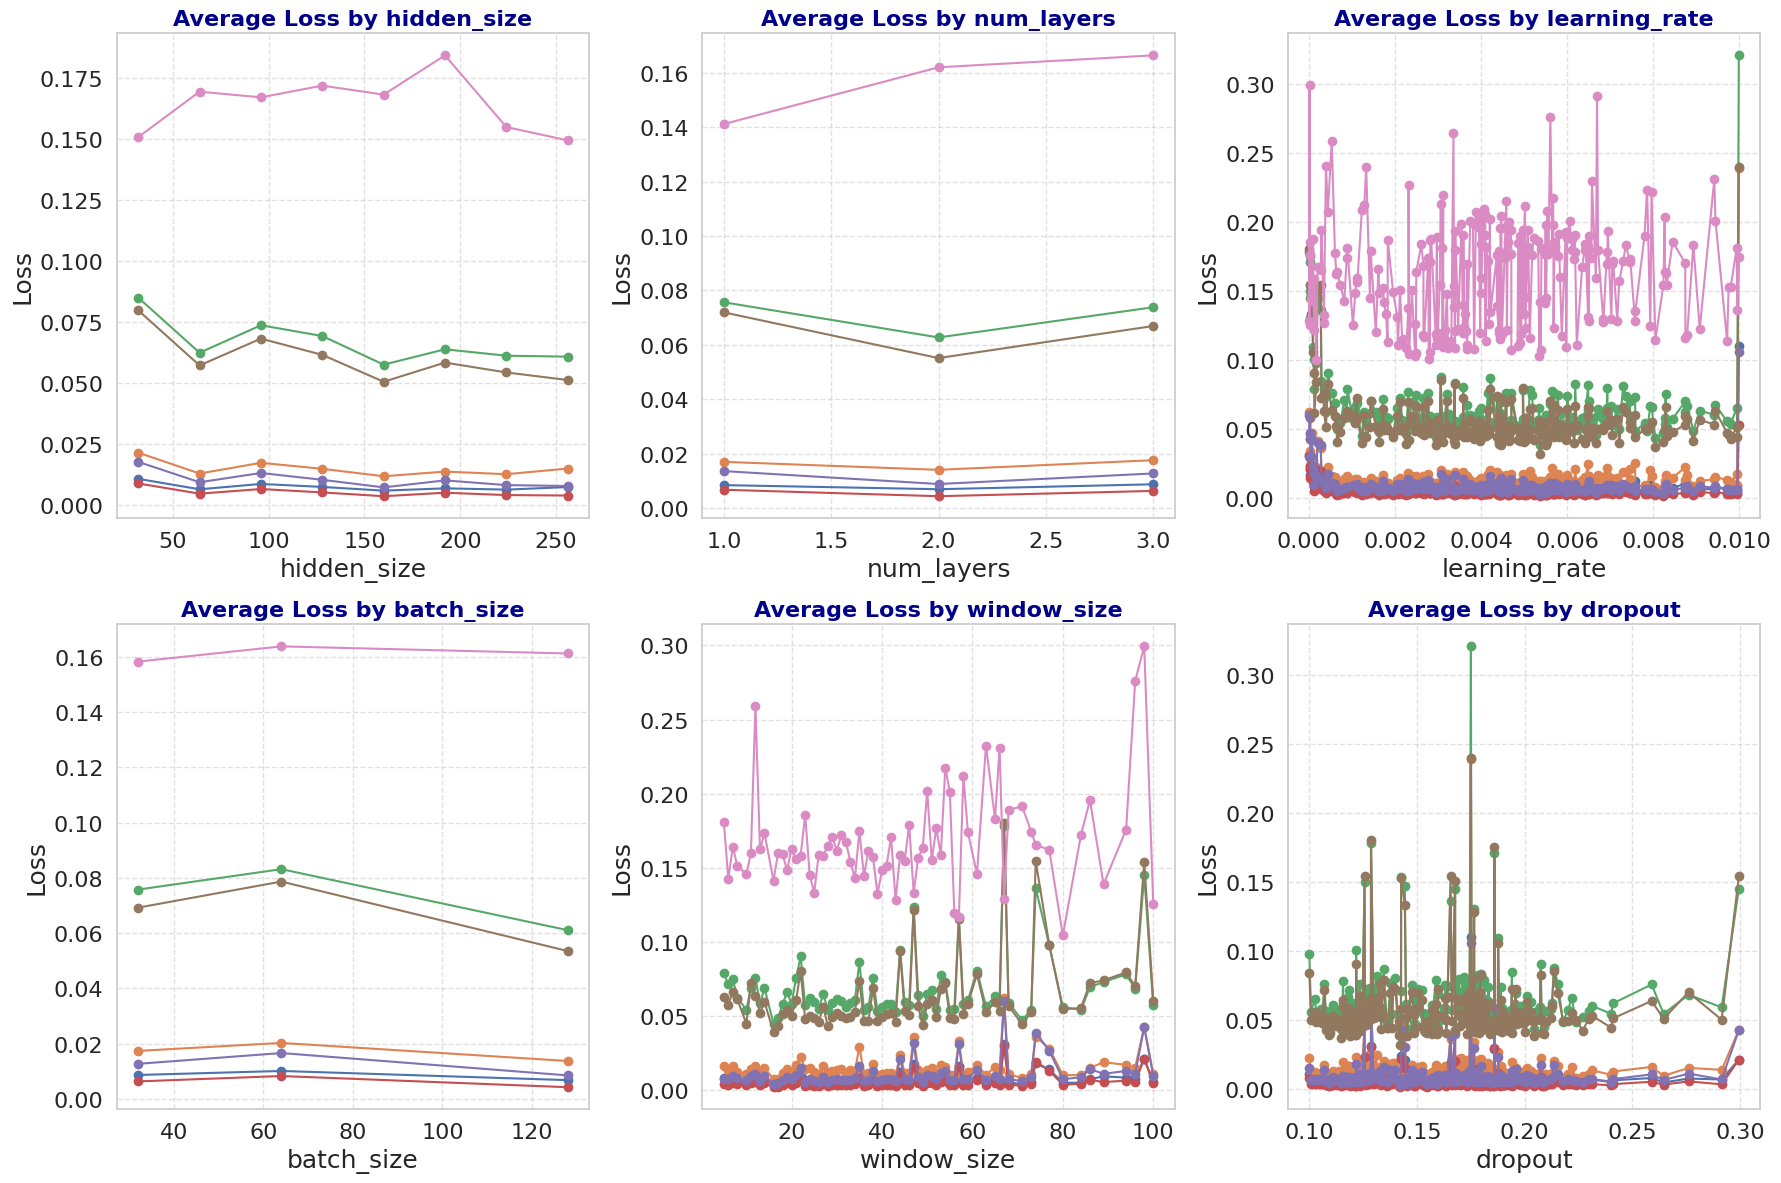

In [10]:
def plot_metrics_by_parameters(metrics_df, parameters, save_path="metrics_by_parameters.png"):
    """
    Create a single figure with subplots for each parameter, showing average losses.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        parameters (list): List of parameters to plot (e.g., ['hidden_size', 'num_layers']).
    """
    # Mapping loss types to more readable names
    loss_type_mapping = {
        "train_HuberLoss": "Train Huber Loss",
        "train_MSE": "Train MSE",
        "train_MAE": "Train MAE",
        "val_HuberLoss": "Validation Huber Loss",
        "val_MSE": "Validation MSE",
        "val_MAE": "Validation MAE",
        "dropout": "Dropout"
    }

    num_params = len(parameters)
    ncols = 3  # Number of columns
    nrows = 2  # Fixed to 2 rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        grouped = metrics_df.groupby(parameter).mean()  # Group by the parameter and calculate averages
        for loss, readable_name in loss_type_mapping.items():
            if loss in grouped.columns:
                ax.plot(grouped.index, grouped[loss], label=readable_name, marker='o', linestyle='-', linewidth=1.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(f"Average Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        if j == len(parameters):  # Use the first unused subplot for the legend
            handles, labels = ax.get_legend_handles_labels()
            axes[j].legend(
                handles, labels, loc="center", fontsize=16, title="Loss Type", title_fontsize=20, frameon=False
            )
            axes[j].set_axis_off()  # Turn off the axis for the legend plot
        else:
            fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example: Plot average losses for all parameters in one figure
parameters_to_plot = ["hidden_size", "num_layers", "learning_rate", "batch_size", "window_size", "dropout"]
plot_metrics_by_parameters(all_metrics_df, parameters_to_plot)

### Predict the next 200 data points recursively

<ipython-input-11-a0d0c69097d0>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)  # Use the first sequence as the initial window


first 10 predictions: [0.2293235957622528, 0.4208759665489197, 0.4563330411911011, 0.2464783489704132, 0.12082070112228394, 0.08952898532152176, 0.12045074999332428, 0.2606915831565857, 0.5128574371337891, 0.4746878147125244]


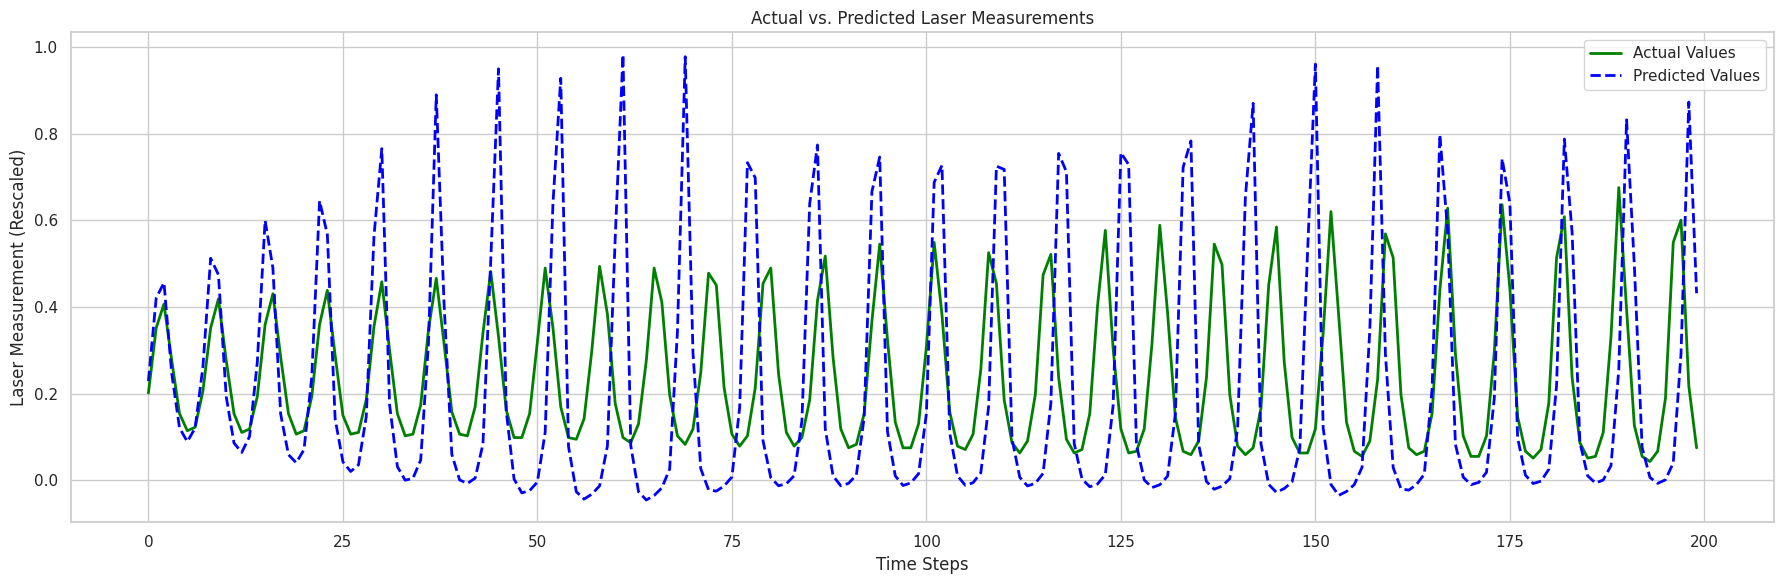

Metrics plot saved to actual_vs_predicted_plot.png


In [11]:
def recursive_forecast(model, init_window, steps=200):
    """
    Perform recursive forecasting using the trained model.

    Args:
        model: The trained Transformer model.
        init_window: The initial sequence window (tensor).
        steps: Number of forecasting steps.
        std: Standard deviation used for normalization.
        mean: Mean used for normalization.

    Returns:
        np.array: Forecasted values rescaled to the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            # Append the prediction
            preds.append(pred_value)

            next_value = torch.tensor([[pred_value]], dtype=torch.float32,  device=device)  # Convert to tensor for concatenation

            # Update the sequence by appending the prediction and removing the oldest value
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)  # Update the sequence
            # # Optional: Clamp predictions to avoid divergence
            # current_seq = torch.clamp(current_seq, min=-3, max=3)  # Adjust range based on normalized data

    print(f"first 10 predictions: {preds[:10]}")
    preds = np.array(preds)
    return preds

def plot_signals(predictions_rescaled, actual_values, save_path="actual_vs_predicted_plot.png"):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Plot Actual vs Predicted Values
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title("Actual vs. Predicted Laser Measurements")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")

# Perform recursive forecasting to generate predictions
init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)  # Use the first sequence as the initial window
predicted_signal = recursive_forecast(best_model, init_window, steps=200)
actual_signal = val_y[:len(predicted_signal)] # Rescale to the original range

plot_signals(predicted_signal, actual_signal)

In [12]:
import torch.nn as nn

def evaluate_model_on_validation(best_model, val_loader):
    """
    Evaluate the best model on the validation dataset and calculate MSE and MAE using PyTorch loss functions.

    Args:
        best_model: The trained model.
        val_loader: The validation dataset (normalized).

    Returns:
        mse: Mean Squared Error.
        mae: Mean Absolute Error.
    """
    # Switch the model to evaluation mode
    best_model.eval()

    # Define PyTorch loss functions
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    # Collect predictions and ground truth
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = best_model(x_batch)

            # Calculate losses
            mse = mse_criterion(output, y_batch).item()
            mae = mae_criterion(output, y_batch).item()

            # Accumulate losses
            total_mse += mse * x_batch.size(0)
            total_mae += mae * x_batch.size(0)
            num_samples += x_batch.size(0)

    # Calculate average losses
    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    print(f"Validation MSE: {avg_mse}")
    print(f"Validation MAE: {avg_mae}")

    return avg_mse, avg_mae

# Evaluate the best model
mse, mae = evaluate_model_on_validation(best_model, val_loader)

Validation MSE: 0.0008082572774483113
Validation MAE: 0.02093753196435784


### Load the trained model

In [13]:
import json

def load_best_model():
    # Load the best hyperparameters
    with open("best_hyperparameters.json", "r") as f:
        best_params = json.load(f)

    # Recreate the model with the best hyperparameters
    best_model = GRU(
        input_size=1,
        hidden_size=best_params["hidden_size"],
        num_stacked_layers=best_params["num_layers"],
        dropout=best_params["dropout"]
    ).to(device)

    # Load the saved model weights
    best_model.load_state_dict(torch.load("best_model.pth"))
    best_model.eval()

    return best_model, best_params

best_model, best_params = load_best_model()
print("Best hyperparameters are:", best_params)

Best hyperparameters are: {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 0.008313327465723452, 'batch_size': 128, 'window_size': 32, 'dropout': 0.1545628676333751}
